In [1]:
from Supporting_functions import *

import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

# Predictions for different models


In [5]:
# Define paths

modelName = 'membranes2membranes'

# Models
srcpath = r'/home/hmorales/WorkSpace/DataIsoReconstructions/'+modelName+'/'
path_models = srcpath+'checkpoint/saved_models/deblur/'

# Image to test
img_src_path = '/home/hmorales/WorkSpace/DataIsoReconstructions/test_data/'
img_test_path = os.path.join(img_src_path, 'memRFPhisGFP_20230821_T010_A001_membranes_raw.tif')
img_gt_path = os.path.join(img_src_path, 'Membranes_RL30.tif')
scale=0.23160005

#output dri
outdir = img_src_path+'/res_'+modelName+'/'
outsufix = 'Self_Net_output_'+modelName

# CUDA device
device1 = torch.device('cuda:0')
device2 = torch.device('cuda:0')

# Image Normalization
min_v = 0
max_v = 65535
norm_percentiles = (20.0, 99.999)  #99.9995 For Nuclei, 99.999 for membranes


# Create output folder
if not os.path.exists(outdir):
    os.mkdir(outdir)

Intensity from (322 , 3208) to  (0, 1320) 
Intensity from (0 , 65535) to  (0, 65535) 
(300, 134, 300)
(300, 134, 300)


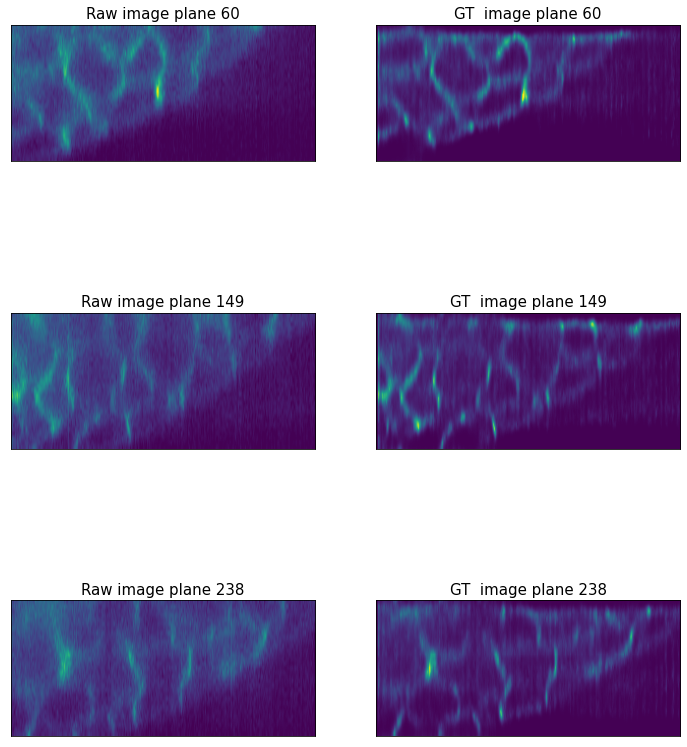

In [3]:
# Load images
raw_img  =  tifffile.imread(img_test_path).astype(np.float32)
gt_img   =  tifffile.imread(img_gt_path).astype(np.float32)

raw_img = image_preprocessing(raw_img, norm_percentiles, min_v, max_v)
gt_img  = image_preprocessing(gt_img, norm_percentiles, min_v, max_v)


raw_img = raw_img[:,200:500,0:300]
gt_img  = gt_img[:,200:500,0:300]

# plot some axial planes

raw_img_xz  =reslice(raw_img,'xz',scale,1)
gt_img_xz  = np.transpose(gt_img,[1,0,2])
raw_img_intep = np.transpose(raw_img_xz,[1,0,2])


print(raw_img_xz.shape)
print(gt_img_xz.shape)

    
def show(ax, image, title):
    ax.imshow(image, cmap='viridis', vmin=0, vmax=65535)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(title,fontsize=15)
    
fig = plt.figure(figsize=(12,15))
axs = fig.subplots(3,2)
dplane = int(0.2*raw_img_xz.shape[0])

for i, idx in enumerate(range(dplane,raw_img_xz.shape[0], int(0.5*(raw_img_xz.shape[0]-2*dplane))-1)):   
    subtitle0 = f"Raw image plane {idx}" 
    subtitle1 = f"GT  image plane {idx}" 
    show(axs[i,0], raw_img_xz[idx,:,:], subtitle0)
    show(axs[i,1], gt_img_xz[idx,:,:], subtitle1)    


In [4]:
# Prepare networks
deblur_net_A = Self_net_architecture.define_G(input_nc=1, output_nc=1, ngf=64, netG='deblur_net', device=device1,use_dropout=False,norm='instance')
deblur_net_B = Self_net_architecture.define_G(input_nc=1, output_nc=1, ngf=64, netG='deblur_net', device=device1,use_dropout=False,norm='instance')


# Get all models ('pkl' files) in the folder
model_names = [f for f in os.listdir(path_models) if f.endswith('.pkl')]
model_names.sort(key=custom_sort)

# Calculate for each model
for i, model_name in enumerate(model_names):

    start_time = time.time()  # Record the start time    
    img = raw_img
    model_path = os.path.join(path_models,model_name);
    # Load Model
    deblur_net_A.load_state_dict(torch.load(model_path))
    deblur_net_B.load_state_dict(torch.load(model_path))
    # Predict image
    fusion_stack=upsample_block(img,scale,1,deblur_net_A,deblur_net_B,min_v,max_v, device1, device2)
    
    #newimg_min = np.amin(fusion_stack)
    #newimg_max = np.amax(fusion_stack)	
    #print('fusion_stack  (%d, %d) ' % (newimg_min, newimg_max), '\n')
    
    # Save result
    outName = outdir+'Self_Net_output'+model_name+'.tif';
    tifffile.imwrite(outName,fusion_stack)
    
    elapsed_time = time.time() - start_time
    print(f"Elapsed Time: {elapsed_time:.4f} seconds, model{model_name}")


initialize network with normal
initialize network with normal
Elapsed Time: 8.6687 seconds, modeldeblur_net_1_1200.pkl
Elapsed Time: 5.8212 seconds, modeldeblur_net_1_2400.pkl
Elapsed Time: 5.8582 seconds, modeldeblur_net_1_3600.pkl
Elapsed Time: 5.8581 seconds, modeldeblur_net_1_4800.pkl
Elapsed Time: 5.8571 seconds, modeldeblur_net_1_6000.pkl
Elapsed Time: 5.8371 seconds, modeldeblur_net_1_7200.pkl
Elapsed Time: 5.8546 seconds, modeldeblur_net_1_8400.pkl
Elapsed Time: 5.8300 seconds, modeldeblur_net_1_9600.pkl
Elapsed Time: 5.8375 seconds, modeldeblur_net_1_10800.pkl
Elapsed Time: 5.8378 seconds, modeldeblur_net_1_12000.pkl
Elapsed Time: 5.8184 seconds, modeldeblur_net_1_13200.pkl
Elapsed Time: 5.8463 seconds, modeldeblur_net_1_14400.pkl
Elapsed Time: 5.9120 seconds, modeldeblur_net_2_1200.pkl
Elapsed Time: 5.8931 seconds, modeldeblur_net_2_2400.pkl
Elapsed Time: 5.8361 seconds, modeldeblur_net_2_3600.pkl
Elapsed Time: 5.8084 seconds, modeldeblur_net_2_4800.pkl
Elapsed Time: 5.8603 s

Elapsed Time: 5.8077 seconds, modeldeblur_net_12_13200.pkl
Elapsed Time: 5.8719 seconds, modeldeblur_net_12_14400.pkl
Elapsed Time: 5.8248 seconds, modeldeblur_net_13_1200.pkl
Elapsed Time: 5.8240 seconds, modeldeblur_net_13_2400.pkl
Elapsed Time: 5.8434 seconds, modeldeblur_net_13_3600.pkl
Elapsed Time: 5.8444 seconds, modeldeblur_net_13_4800.pkl
Elapsed Time: 5.8407 seconds, modeldeblur_net_13_6000.pkl
Elapsed Time: 5.8026 seconds, modeldeblur_net_13_7200.pkl
Elapsed Time: 5.8330 seconds, modeldeblur_net_13_8400.pkl
Elapsed Time: 5.8563 seconds, modeldeblur_net_13_9600.pkl
Elapsed Time: 5.8424 seconds, modeldeblur_net_13_10800.pkl
Elapsed Time: 5.8507 seconds, modeldeblur_net_13_12000.pkl
Elapsed Time: 5.8183 seconds, modeldeblur_net_13_13200.pkl
Elapsed Time: 5.8527 seconds, modeldeblur_net_13_14400.pkl
Elapsed Time: 5.8226 seconds, modeldeblur_net_14_1200.pkl
Elapsed Time: 5.8138 seconds, modeldeblur_net_14_2400.pkl
Elapsed Time: 5.8537 seconds, modeldeblur_net_14_3600.pkl
Elapsed 

Elapsed Time: 5.8108 seconds, modeldeblur_net_24_9600.pkl
Elapsed Time: 5.8206 seconds, modeldeblur_net_24_10800.pkl
Elapsed Time: 5.8074 seconds, modeldeblur_net_24_12000.pkl
Elapsed Time: 5.9448 seconds, modeldeblur_net_24_13200.pkl
Elapsed Time: 5.8798 seconds, modeldeblur_net_24_14400.pkl
Elapsed Time: 5.9721 seconds, modeldeblur_net_25_1200.pkl
Elapsed Time: 6.0172 seconds, modeldeblur_net_25_2400.pkl
Elapsed Time: 5.9753 seconds, modeldeblur_net_25_3600.pkl
Elapsed Time: 6.0126 seconds, modeldeblur_net_25_4800.pkl
Elapsed Time: 5.9745 seconds, modeldeblur_net_25_6000.pkl
Elapsed Time: 5.9566 seconds, modeldeblur_net_25_7200.pkl
Elapsed Time: 5.8656 seconds, modeldeblur_net_25_8400.pkl
Elapsed Time: 6.0083 seconds, modeldeblur_net_25_9600.pkl
Elapsed Time: 5.8565 seconds, modeldeblur_net_25_10800.pkl
Elapsed Time: 5.8975 seconds, modeldeblur_net_25_12000.pkl
Elapsed Time: 5.8505 seconds, modeldeblur_net_25_13200.pkl
Elapsed Time: 5.8345 seconds, modeldeblur_net_25_14400.pkl
Elapse

Elapsed Time: 5.9244 seconds, modeldeblur_net_36_6000.pkl
Elapsed Time: 6.0021 seconds, modeldeblur_net_36_7200.pkl
Elapsed Time: 5.8823 seconds, modeldeblur_net_36_8400.pkl
Elapsed Time: 6.0657 seconds, modeldeblur_net_36_9600.pkl
Elapsed Time: 5.9967 seconds, modeldeblur_net_36_10800.pkl
Elapsed Time: 5.8908 seconds, modeldeblur_net_36_12000.pkl
Elapsed Time: 5.9820 seconds, modeldeblur_net_36_13200.pkl
Elapsed Time: 5.9013 seconds, modeldeblur_net_36_14400.pkl
Elapsed Time: 5.8267 seconds, modeldeblur_net_37_1200.pkl
Elapsed Time: 5.8729 seconds, modeldeblur_net_37_2400.pkl
Elapsed Time: 5.9438 seconds, modeldeblur_net_37_3600.pkl
Elapsed Time: 5.8991 seconds, modeldeblur_net_37_4800.pkl
Elapsed Time: 5.9732 seconds, modeldeblur_net_37_6000.pkl
Elapsed Time: 5.8949 seconds, modeldeblur_net_37_7200.pkl
Elapsed Time: 5.8516 seconds, modeldeblur_net_37_8400.pkl
Elapsed Time: 5.9108 seconds, modeldeblur_net_37_9600.pkl
Elapsed Time: 5.8797 seconds, modeldeblur_net_37_10800.pkl
Elapsed T

Elapsed Time: 2.9833 seconds, modeldeblur_net_48_2400.pkl
Elapsed Time: 3.0381 seconds, modeldeblur_net_48_3600.pkl
Elapsed Time: 3.0422 seconds, modeldeblur_net_48_4800.pkl
Elapsed Time: 2.9844 seconds, modeldeblur_net_48_6000.pkl
Elapsed Time: 3.0021 seconds, modeldeblur_net_48_7200.pkl
Elapsed Time: 2.9993 seconds, modeldeblur_net_48_8400.pkl
Elapsed Time: 3.0138 seconds, modeldeblur_net_48_9600.pkl
Elapsed Time: 2.9943 seconds, modeldeblur_net_48_10800.pkl
Elapsed Time: 3.0044 seconds, modeldeblur_net_48_12000.pkl
Elapsed Time: 2.9764 seconds, modeldeblur_net_48_13200.pkl
Elapsed Time: 2.9814 seconds, modeldeblur_net_48_14400.pkl
Elapsed Time: 3.0804 seconds, modeldeblur_net_49_1200.pkl
Elapsed Time: 2.9972 seconds, modeldeblur_net_49_2400.pkl
Elapsed Time: 3.0706 seconds, modeldeblur_net_49_3600.pkl
Elapsed Time: 2.9951 seconds, modeldeblur_net_49_4800.pkl
Elapsed Time: 2.9956 seconds, modeldeblur_net_49_6000.pkl
Elapsed Time: 3.0116 seconds, modeldeblur_net_49_7200.pkl
Elapsed Ti

FileNotFoundError: [Errno 2] No such file or directory: '/home/hmorales/WorkSpace/DataIsoReconstructions/membranes2membranes/checkpoint/saved_models/deblur_net_54_14400.pkl'

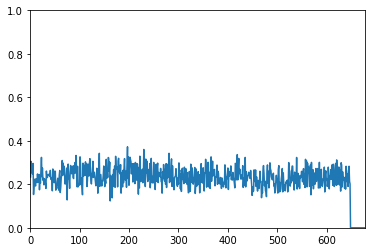

FileNotFoundError: [Errno 2] No such file or directory: '/home/hmorales/WorkSpace/DataIsoReconstructions/test_data/res_membranes2membranes/Self_Net_outputdeblur_net_54_14400.pkl.tif'

In [19]:
from skimage import io
from skimage.metrics import structural_similarity as ssim


# get stats of predictions and GT

Nmodels= len(model_names)
model_idx = np.linspace(1,Nmodels,Nmodels)


# crop image GT and reference

ref_img = raw_img_intep[35:100,:,:]
gt_scaled_img  = gt_img[35:100,:,:]



# SSIM

y = np.empty_like(model_idx)
y[:] = 0 #np.nan


fig, ax = plt.subplots()
line, = ax.plot(model_idx, y) 
ax.set_xlim(0, Nmodels+1)
ax.set_ylim(0.0, 1.0)


# Calculate for each model
for idx, model_name in enumerate(model_names):
    # open result
    outName = outdir+'Self_Net_output'+model_name+'.tif';
    res_img  =  tifffile.imread(outName).astype(np.float32)   
    res_img = res_img[35:100,:,:]
   
    # Get anisotopy
    ssim_value = ssim(gt_scaled_img, res_img, gaussian_weights=True) 
    
    #eigen_pred = skimage.measure.inertia_tensor_eigvals(res_img)
    #a_pred = eigen_pred[2]/eigen_pred[0]

  
    y[idx] = ssim_value
    #yGT[idx] = a_GT
    
    # Update the plot
    line.set_ydata(y)
    #lineGT.set_ydata(yGT)
    clear_output(wait=True)  # Clear the previous plot
    display(fig)
    
    # Close the figure when the loop is done
    plt.close(fig)
    #print(a_pred)
    

In [21]:
# Get min error

max_value = np.max(y)
max_index = 202 #np.argmax(y)

print("Maximum Value:", max_value)
print("Index of Maximum Value:", max_index)
print("Model Maximum Value:", model_names[max_index])

outName = img_src_path+outsufix+'_gt.tif';
tifffile.imwrite(outName,gt_img)

outName = img_src_path+outsufix+'_raw.tif';
tifffile.imwrite(outName,raw_img_intep)

outName = outdir+'Self_Net_output'+model_names[max_index]+'.tif';   
res_img  =  tifffile.imread(outName).astype(np.float32)   
res_img = res_img#[35:100,:,:]
outName = img_src_path+outsufix+'_pred_'+model_names[max_index]+'.tif';
tifffile.imwrite(outName,res_img)


Maximum Value: 0.37246445667008726
Index of Maximum Value: 202
Model Maximum Value: deblur_net_17_13200.pkl
